# Project Milestone 2 : _Was Trump's Impact on Fake News Spread during Covid truly Significant?_

---
## Context

__TODO:__ Put abstract here (just 150 words, not full 1000)?

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud

---
## Part 1: Causal Impact Analysis of Trump's Tweets on Wikipedia Pageviews

### A) We start by preparing and familiarizing with our data
- Import & describe (source, size, columns, etc -> similar to homework/tutorials) datasets used for this part
    - Datasets: DT tweets + Wikipedia pageviews
- Preprocess: format, missing values, filtering, transforming, enriching (cf. homework 1) 

### B) We can now perform our first causal analyses
_Note:_ For every piece of analysis, we should briefly explain the theory/math (document this!), include visualizations & statistical tests and (optionally?) model training

__Proposed analysis pipeline__ for this part 1.B:
- Matteo's analysis leading to the very interesting Wikipedia pageviews - DT tweet plot
- Causal analysis with Google library (as we need the events - DT tweets - to know where to expect a causal effect): https://google.github.io/CausalImpact/CausalImpact.html
- Granger causality test: "Is Trump leading or following the trend?"
- Some model training (You think that's relevant? Ask Manoel?)

In [75]:
custom_date = lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d')
df = pd.read_csv('tweets.csv', parse_dates=['date'], date_parser=custom_date)

/tmp/ipykernel_43159/24167535.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('tweets.csv', parse_dates=['date'], date_parser=custom_date)


In [76]:
df.sample(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
22923,324706150077591552,"""""""@mtneerjustice: @realDonaldTrump My husband...",f,f,Twitter for Android,5,13,2013-04-18,f
52454,1169756027035803650,Just spoke to Governor @HenryMcMaster of South...,f,f,Twitter for iPhone,38106,7147,2019-09-05,f
45529,835173525522624512,Trump vows to fight 'epidemic' of human traffi...,f,f,Twitter for iPhone,77897,16609,2017-02-24,f
30215,457837013237252096,"""""""@WasimPerviz: @realDonaldTrump When will we...",f,f,Twitter for Android,136,131,2014-04-20,f
49970,1203097476842053635,Congressman @LanceGooden has done a wonderful ...,f,f,Twitter for iPhone,35824,11109,2019-12-06,f


In [77]:
df.isna().sum()

id           0
text         0
isRetweet    0
isDeleted    0
device       0
favorites    0
retweets     0
date         0
isFlagged    0
dtype: int64

Let's focus on covid dates

In [78]:
df_covid = df[df['date'] >= '2019-12-01']
df_covid.sort_values(by='date')

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
5729,1201207249953263617,"On World AIDS Day, The First Lady and I expres...",f,f,Twitter for iPhone,88404,17422,2019-12-01,f
4461,1200948772253118465,"“Sen. Tim Scott Says Trump 'Innocent,' 'No Way...",f,f,Twitter for iPhone,52381,14045,2019-12-01,f
5731,1200949221224001536,"“Trump did nothing impeachable, day-by-day rev...",f,f,Twitter for iPhone,46554,12497,2019-12-01,f
5728,1201207251035467776,"....in America, community by community where w...",f,f,Twitter for iPhone,51297,10488,2019-12-01,f
5730,1200949712087638017,“Schiff’s impeachment hearings wasting time wh...,f,f,Twitter for iPhone,78199,19648,2019-12-01,f
...,...,...,...,...,...,...,...,...,...
252,1346822610957561858,The States want to redo their votes. They foun...,f,f,Twitter for iPhone,303347,69832,2021-01-06,f
212,1346693906990305280,Get smart Republicans. FIGHT! https://t.co/3fs...,f,f,Twitter for iPhone,127234,26083,2021-01-06,f
316,1347334804052844550,https://t.co/csX07ZVWGe,f,f,Twitter Media Studio,629326,154877,2021-01-08,f
327,1347569870578266115,"To all of those who have asked, I will not be ...",f,f,Twitter for iPhone,510761,83532,2021-01-08,f


In [79]:
time_span = pd.date_range(start = min(df_covid['date']), end = max(df_covid['date']), freq='D')

In [80]:
data=df_covid.copy()
data = pd.merge(data, pd.DataFrame(time_span, columns=['date']), on='date', how='right')

print(data[data.isna()])
#only one nan let'd drop it
data.dropna(inplace=True)
data['per_day_tweets']= data.groupby('date')['date'].transform('count')
data['per_day_retweets']= data.groupby('date')['retweets'].transform('sum')
data['per_day_likes']= data.groupby('date')['favorites'].transform('sum')

       id text isRetweet isDeleted device  favorites  retweets date isFlagged
0     NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
1     NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
2     NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
3     NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
4     NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
...    ..  ...       ...       ...    ...        ...       ...  ...       ...
13514 NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
13515 NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
13516 NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
13517 NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN
13518 NaN  NaN       NaN       NaN    NaN        NaN       NaN  NaT       NaN

[13519 rows x 9 columns]


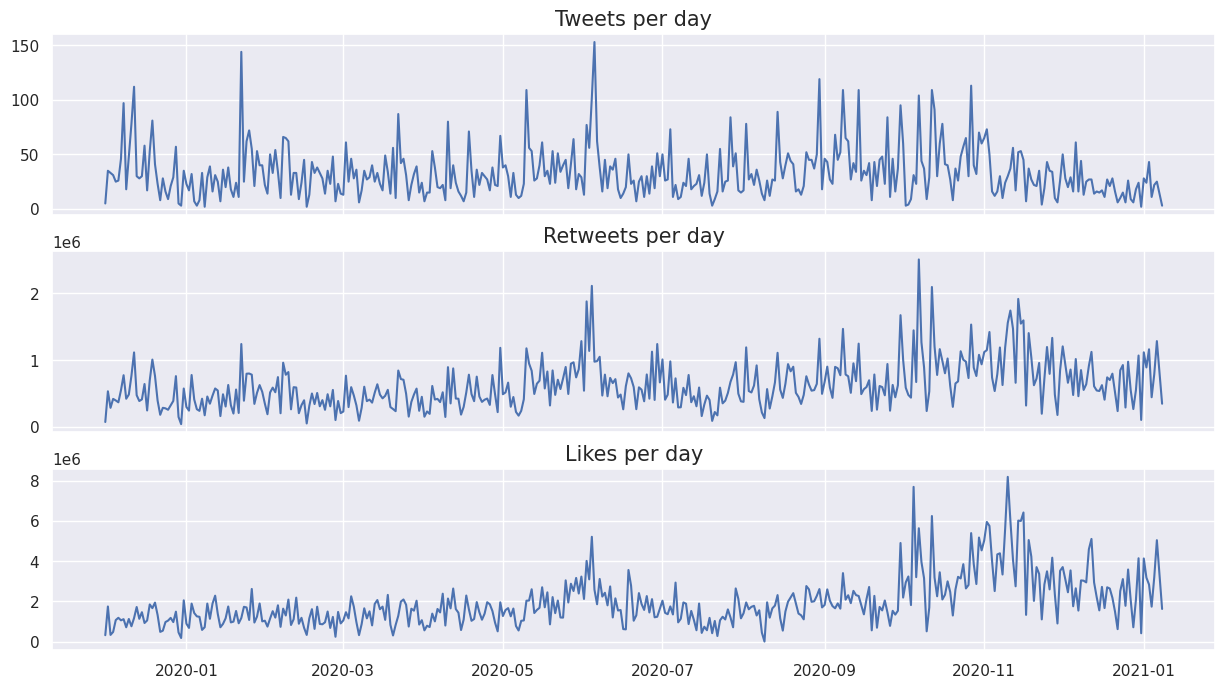

In [81]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex=True, sharey=False)

axes[0].plot(data['date'], data['per_day_tweets'])
axes[0].set_title('Tweets per day', size=15)
axes[1].plot(data['date'], data['per_day_retweets'])
axes[1].set_title('Retweets per day', size=15)
axes[2].plot(data['date'], data['per_day_likes'])
axes[2].set_title('Likes per day', size=15)


plt.show()

There's a correlation between the variables

In [82]:
corr_number_retweets = np.corrcoef(data['per_day_tweets'], data['per_day_retweets'])
print(f'Correlation Coefficient: {corr_number_retweets[0, 1]:.2f}')
corr_number_likes = np.corrcoef(data['per_day_tweets'], data['per_day_likes'])
print(f'Correlation Coefficient: {corr_number_likes[0, 1]:.2f}')
corr_number_likes_retweets = np.corrcoef(data['per_day_retweets'], data['per_day_likes'])
print(f'Correlation Coefficient: {corr_number_likes_retweets[0, 1]:.2f}')


Correlation Coefficient: 0.66
Correlation Coefficient: 0.26
Correlation Coefficient: 0.78


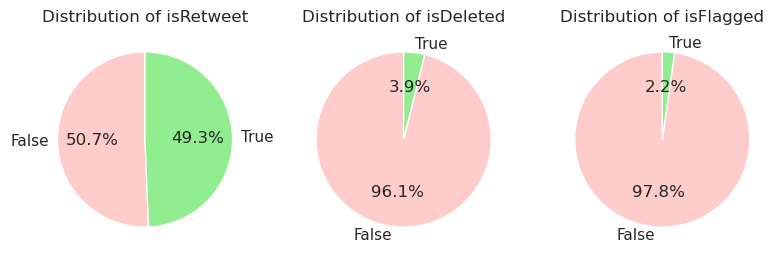

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(8, 12))

variables = ['isRetweet', 'isDeleted', 'isFlagged']
colors = ['#FFCCCC', 'lightgreen']

for i, var in enumerate(variables):
    ax = axes[i]
    ax.pie(data[var].value_counts(), labels=['False', 'True'], autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(f'Distribution of {var}')

plt.tight_layout()
plt.show()


Let's focus on covid topics

Before running following command install dictionary with:

python -m spacy download en_core_web_sm

In [84]:
#download a english dictionary to make anlysis
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))

Number of stop words: 326


In [85]:
#put all the text togheter
result_text = ' '.join(data['text'])

def remove_stopwords(chunk):
    return ' '.join([token.text for token in chunk if (not token.is_stop)])


#max length for spaCy nlp
chunk_size = 100000
chunks = [result_text[i:i+chunk_size] for i in range(0, len(result_text), chunk_size)]

# Process each chunk separately
processed_chunks = [nlp(chunk) for chunk in chunks]
processed_chunks_no_stopwords = [remove_stopwords(chunk) for chunk in processed_chunks]

In [86]:
clean = ' '.join(processed_chunks_no_stopwords)
clean= re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',clean)
clean= clean.translate(str.maketrans('', '', string.punctuation))
clean = clean.replace('amp', '')
clean = clean.replace('RT', '')
clean = clean.replace('realDonaldTrump', '')


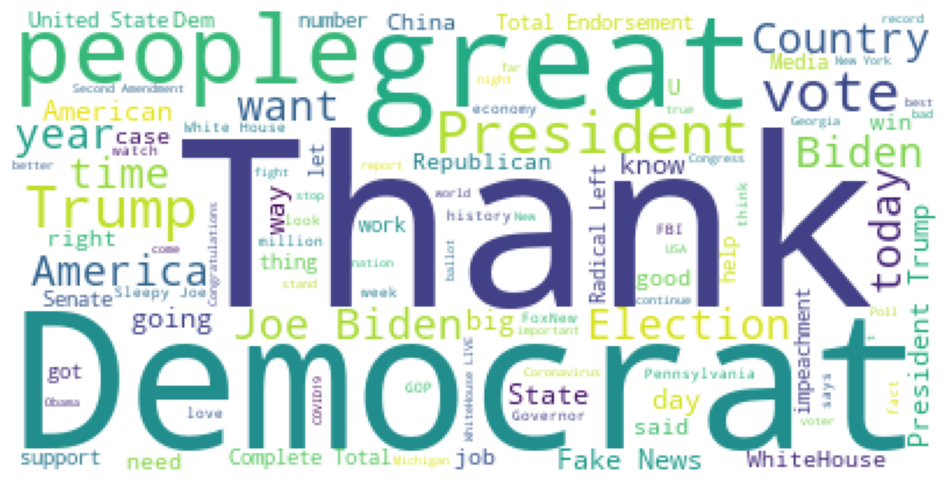

In [87]:
#generating the wordcloud
wordcloud = WordCloud(background_color="white").generate(clean)

#plot the wordcloud
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)

#to remove the axis value
plt.axis("off")
plt.show()

In [88]:
list_of_words = ['Covid19', 'virus', 'China', 'vaccine', 'Flu', 'Covid', 'lockdown', 'pandemic', 'coronavirus', 'Coronavirus', 'Corona', 'corona', 'COVID19', 'COVID', 'covid', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantined', 'Quarantined', 'quarentined', 'Quarentined', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines']
data['covid_related'] = data['text'].apply(lambda x: True if any(word in x for word in list_of_words) else False)

data['covid_related'].value_counts()

covid_related
False    12662
True       856
Name: count, dtype: int64

Find the moment when the topic is the most popular

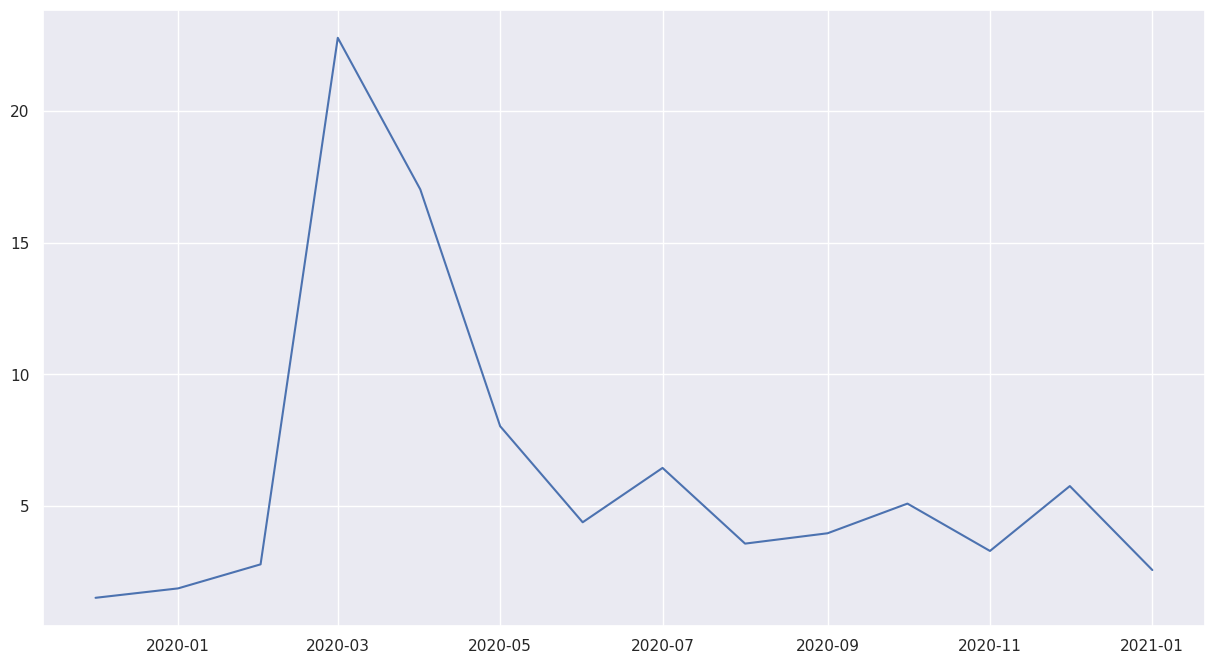

In [90]:
#fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex=True, sharey=False)
data['month_date'] = data.date.apply(lambda x: x.month)
data['year_date'] = data.date.apply(lambda x: x.year)
frequency_plot = data.groupby(by=['month_date', 'year_date']).apply(lambda x: x.covid_related.sum() / x.covid_related.count()).reset_index()
frequency_plot['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot.month_date.values, frequency_plot.year_date.values)]
frequency_plot = frequency_plot.sort_values(by='date')
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)

# plt.plot(data['date'], data['id'], c=data['covid_related'], cmap='viridis')
# plt.title('Covid related tweets', size=15)
# plt.show()


Now let's discover if among the most retweeted and the most liked tweets there are some that are related to covid

In [91]:
data['decile_retweeted'] = pd.qcut(data['retweets'], 10, labels=False, duplicates='drop')
data['decile_favorited'] = pd.qcut(data['favorites'], 10, labels=False, duplicates='drop')
data.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,per_day_tweets,per_day_retweets,per_day_likes,covid_related,month_date,year_date,decile_retweeted,decile_favorited
0,1.200949e+18,"“Sen. Tim Scott Says Trump 'Innocent,' 'No Way...",f,f,Twitter for iPhone,52381.0,14045.0,2019-12-01,f,5,74100.0,316835.0,False,12,2019,5,2
1,1.201207e+18,"....in America, community by community where w...",f,f,Twitter for iPhone,51297.0,10488.0,2019-12-01,f,5,74100.0,316835.0,False,12,2019,3,2
2,1.201207e+18,"On World AIDS Day, The First Lady and I expres...",f,f,Twitter for iPhone,88404.0,17422.0,2019-12-01,f,5,74100.0,316835.0,False,12,2019,6,3
3,1.200950e+18,“Schiff’s impeachment hearings wasting time wh...,f,f,Twitter for iPhone,78199.0,19648.0,2019-12-01,f,5,74100.0,316835.0,False,12,2019,6,3
4,1.200949e+18,"“Trump did nothing impeachable, day-by-day rev...",f,f,Twitter for iPhone,46554.0,12497.0,2019-12-01,f,5,74100.0,316835.0,False,12,2019,4,1


In [92]:
data_covid_favorites = data.query('covid_related == True and (decile_favorited == 9 or decile_favorited == 8 or decile_favorited == 7 or decile_retweeted == 9 or decile_retweeted == 8 or decile_retweeted == 7)')

In [93]:
data_covid_favorites.shape

(250, 17)

There are some popular tweets that are related to covid let's see if they also contain words related to possible fake news

In [94]:
data[data.text.str.contains('')].text.values

array(["“Sen. Tim Scott Says Trump 'Innocent,' 'No Way' Senate Convicts” https://t.co/P6ONkI8n0P",
       '....in America, community by community where we will eradicate AIDS in 10 years, program already started. American leadership has proven that together we can save lives.',
       'On World AIDS Day, The First Lady and I express our support for those living with HIV/AIDS and mourn the lives lost. We reaffirm our commitment to end the HIV/AIDS epidemic....',
       ..., 'https://t.co/csX07ZVWGe',
       'The 75,000,000 great American Patriots who voted for me, AMERICA FIRST, and MAKE AMERICA GREAT AGAIN, will have a GIANT VOICE long into the future. They will not be disrespected or treated unfairly in any way, shape or form!!!',
       'To all of those who have asked, I will not be going to the Inauguration on January 20th.'],
      dtype=object)

In [95]:
fake_news = ['Hydroxychloroquine', 'hydroxychloroquine']
analyze = data_covid_favorites['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)

In [96]:
analyze.value_counts()

text
False    249
True       1
Name: count, dtype: int64

### If we don't filter per covid and quantile

In [97]:
analyze1 = data['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)
analyze1.value_counts()

text
False    13496
True        22
Name: count, dtype: int64

### If we don't filter per quantile

In [98]:
dg = data[data['covid_related'] == True]
analyze2 = dg['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)
analyze2.value_counts()

text
False    849
True       7
Name: count, dtype: int64

### If we don't filter per covid

In [99]:
dq = data.query('decile_favorited == 9 or decile_favorited == 8 or decile_favorited == 7 or decile_retweeted == 9 or decile_retweeted == 8 or decile_retweeted == 7')
analyze3 = dg['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)
analyze3.value_counts()

text
False    849
True       7
Name: count, dtype: int64

In [100]:
# create a new column with the result of the analysis
new_col = analyze3.reindex(data.index, fill_value=False)
data['Hydroxychloroquine']=new_col

We should focus on the last one

Text(0.5, 1.0, 'Covid related tweets')

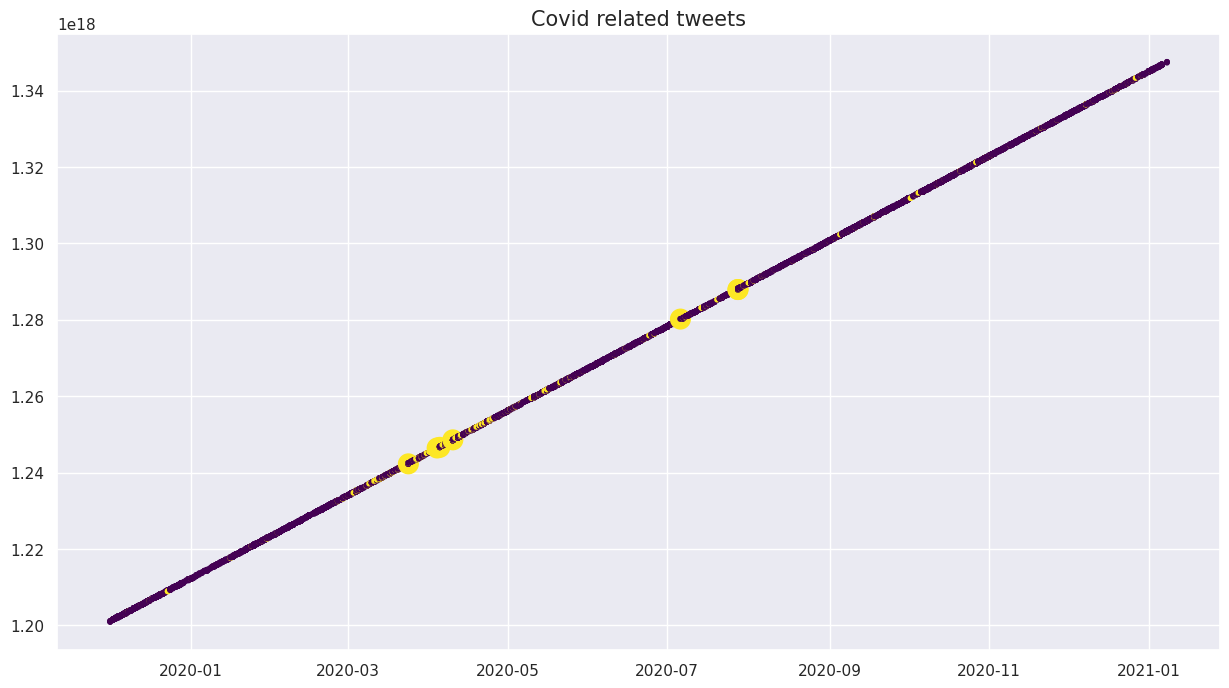

In [101]:
condition = data['Hydroxychloroquine']  # Replace 'condition_column' with your actual column name

# Define the sizes of the dots (10 for False, 50 for True)
sizes = [10 if not cond else 200 for cond in condition]

# Scatter plot with custom sizes
plt.scatter(data['date'], data['id'], c=data['covid_related'], cmap='viridis', s=sizes)

# Add title
plt.title('Covid related tweets', size=15)

In [102]:
trend_data = []

month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# Load JSON data
with open('hydroxychloroquine_googletrends.json', 'r') as file:
    data_views = json.load(file)

    for date in data_views['interest_over_time']['timeline_data']:
        parts = date['date'].replace('–', ' '). replace(',', ' ').split()
        if len(parts) == 6:
            trend_data.append({'date': datetime(year=int(parts[2]), month=month_mapping[parts[0]], day=int(parts[1])), 'value': int(date['values'][0]['value'])})
        else:
            trend_data.append({'date': datetime(year=int(parts[-1]), month=month_mapping[parts[0]], day=int(parts[1])), 'value': int(date['values'][0]['value'])})

# Create DataFrame from the list
trend_df = pd.DataFrame(trend_data)

In [103]:
trend_df

,date,value
0,2020-01-05,1
1,2020-01-12,1
2,2020-01-19,1
3,2020-01-26,1
4,2020-02-02,1
5,2020-02-09,1
6,2020-02-16,1
7,2020-02-23,1
8,2020-03-01,1
9,2020-03-08,2


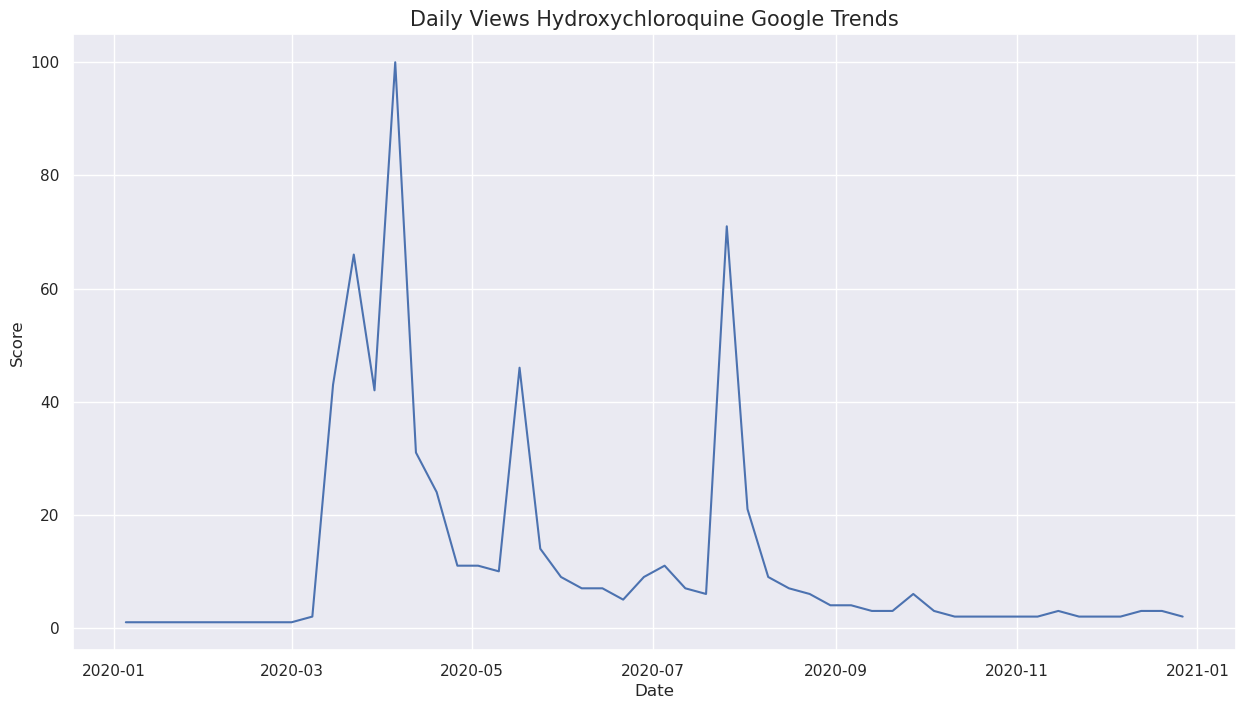

In [104]:

plt.plot(trend_df.date, trend_df.value)
plt.title('Daily Views Hydroxychloroquine Google Trends', size=15)
plt.xlabel('Date')
plt.ylabel('Score')
plt.show()

In [105]:
import pandas as pd
import json

# Load JSON data
with open('hydroxychloroquine_wikipedia.json', 'r') as file:
    data_views = json.load(file)

# Extract dates and views
datess = [item['timestamp'] for item in data_views['items']]
views = [item['views'] for item in data_views['items']]

# Combine dates and views into a list of tuples
date_views_list = list(zip(datess, views))

# Create a Pandas DataFrame
df = pd.DataFrame(date_views_list, columns=['Date', 'Views'])

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d00')

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Convert the 'Views' column to a Pandas Series
views_series = df['Views']


In [106]:
# get the dates where trump spoke
critical_data = data[data['Hydroxychloroquine'] == True]['date']
specific_dates = pd.to_datetime(critical_data, format='%Y%m%d')

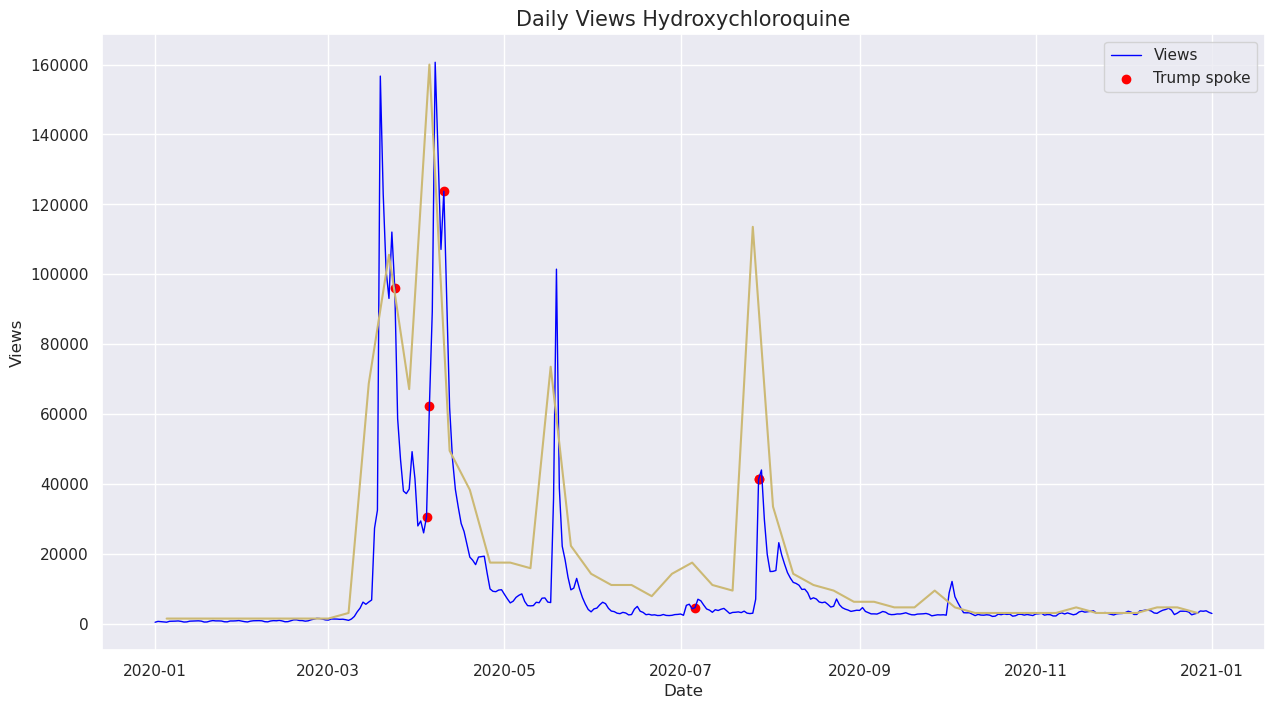

In [112]:
specific_views = views_series.loc[specific_dates]

# Plotting the data
plt.plot(views_series, color='blue', linewidth=1)
plt.scatter(specific_views.index, specific_views, color='red')  # Add red dots
plt.plot(trend_df.date, trend_df.value * 1600, color = 'y')
plt.title('Daily Views Hydroxychloroquine', size=15)
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend(['Views', 'Trump spoke'])
plt.show()

In [108]:
import os

### Code to download wikipedia timeseries of page
## Start of parameters to set
saving_path = 'hydroxychloroquine_wikipedia.json'
page_name = 'Hydroxychloroquine'
start_date = datetime(year=2020, month=1, day=1)
end_date = datetime(year=2021, month=1, day=1)
## End of parameters to set

command = 'wget -O {saving_path} \'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/{page_name}/daily/{start_date}/{end_date}\''\
            .format(saving_path=saving_path, page_name=page_name, start_date=start_date.strftime('%Y%m%d%H'), end_date=end_date.strftime('%Y%m%d%H'))

os.system(command)

--2023-11-15 23:11:52--  https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/Hydroxychloroquine/daily/2020010100/2021010100
Resolving wikimedia.org (wikimedia.org)... 185.15.58.224, 2a02:ec80:600:ed1a::1
Connecting to wikimedia.org (wikimedia.org)|185.15.58.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56927 (56K) [application/json]
Saving to: ‘hydroxychloroquine_wikipedia.json’

     0K .......... .......... .......... .......... .......... 89% 1,52M 0s
    50K .....                                                 100% 38,8M=0,03s

2023-11-15 23:11:52 (1,68 MB/s) - ‘hydroxychloroquine_wikipedia.json’ saved [56927/56927]



0

In [109]:
# to install: pip install google-search-results

from serpapi import GoogleSearch
import json

### Code to download wikipedia timeseries of page
## Start of parameters to set
saving_path = 'hydroxychloroquine_googletrends.json'
page_name = 'Hydroxychloroquine'
start_date = datetime(year=2020, month=1, day=1)
end_date = datetime(year=2021, month=1, day=1)
## End of parameters to set

params = {
  "engine": "google_trends",
  "q": page_name,
  "data_type": "TIMESERIES",
  "api_key": "dd2b1a64c96847db4dc6d2d2146d7eed59a48a6657355d7a5232f91b1f463f25",
  "date": "{start_date} {end_date}".format(start_date=start_date.strftime('%Y-%m-%d'), end_date=end_date.strftime('%Y-%m-%d'))
}

search = GoogleSearch(params)
results = search.get_dict()

json_object = json.dumps(results)
with open(saving_path, 'w') as f:
  f.write(json_object)

___
## Part 2: Causal Impact Analyis of Alternative Hypotheses
__Proposition:__ Conduct analyses similar to the above (though briefer) with:
1) Dataset description + preprocessing
2) Visualiation + Granger causality test + (optionally) model training
on the following data:
- tweets/announcements by other ppl
- interventions (restrictions & co, cf Wikidata)
- mobility reports (Apple/Google)